In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
%matplotlib inline

### Data

In [2]:
df_orig = pd.read_csv('data/daily-minimum-temperatures.csv')
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df

,temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


Text(0, 0.5, 'temperature')

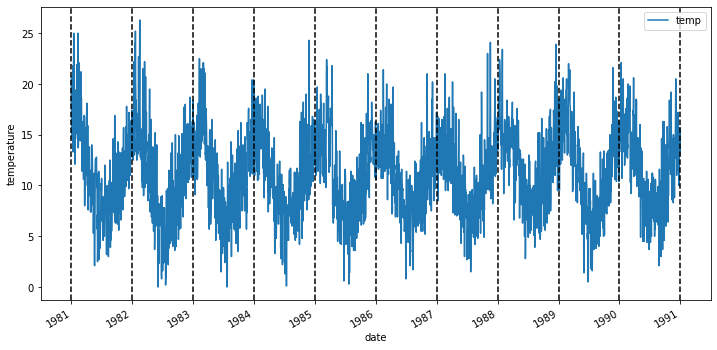

In [3]:
ax = df_orig.plot(x='date', y='temp', figsize=(12,6))
xcoords = ['1981-01-01', '1982-01-01','1983-01-01', '1984-01-01', '1985-01-01', '1986-01-01',
          '1987-01-01', '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

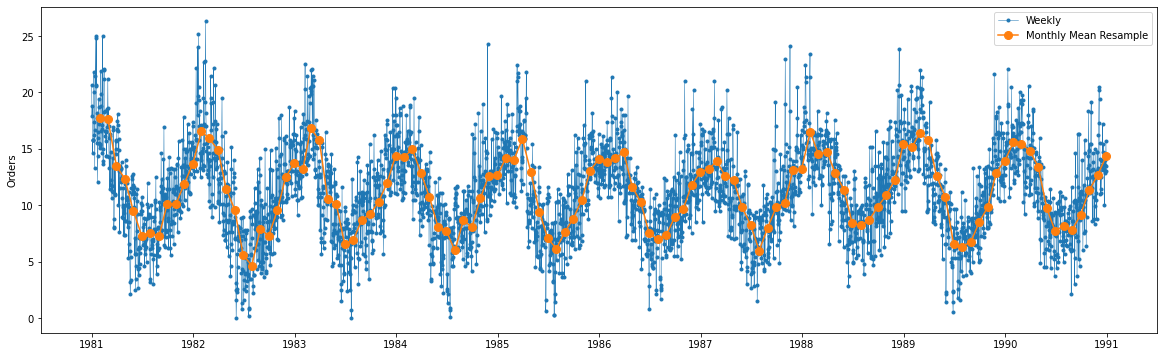

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(df.resample('M').mean(), marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

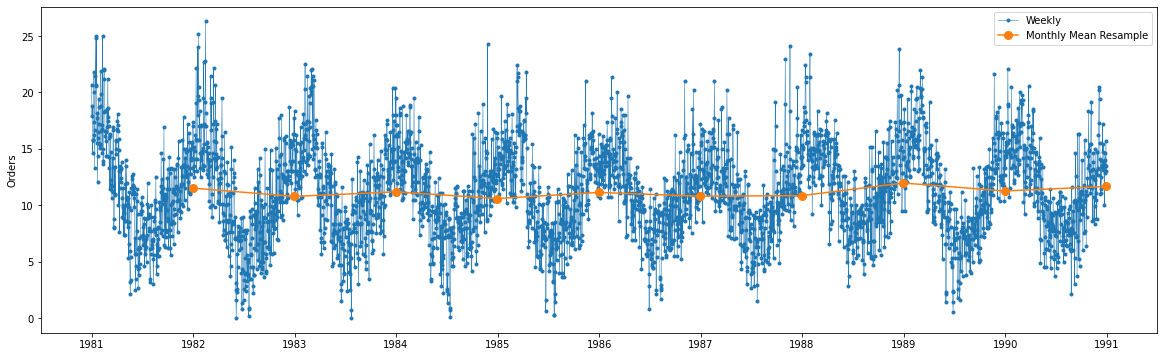

In [5]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(df.resample('Y').mean(), marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

### Decomposing the data

In [6]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

<ipython-input-6-76e7b9524102>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)


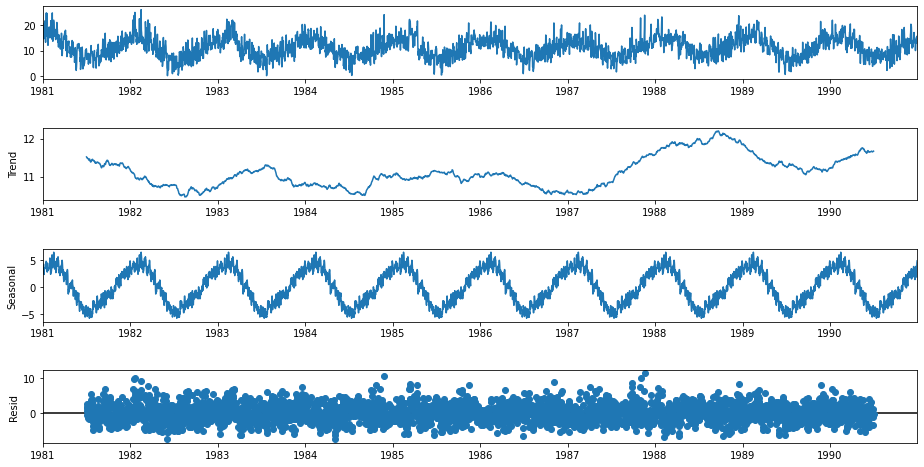

(date
 1981-01-01   NaN
 1981-01-02   NaN
 1981-01-03   NaN
 1981-01-04   NaN
 1981-01-05   NaN
               ..
 1990-12-27   NaN
 1990-12-28   NaN
 1990-12-29   NaN
 1990-12-30   NaN
 1990-12-31   NaN
 Name: trend, Length: 3650, dtype: float64,
 date
 1981-01-01    4.202612
 1981-01-02    3.880025
 1981-01-03    3.124256
 1981-01-04    2.868122
 1981-01-05    2.524804
                 ...   
 1990-12-27    2.442034
 1990-12-28    1.832902
 1990-12-29    2.545200
 1990-12-30    4.423008
 1990-12-31    4.801791
 Name: seasonal, Length: 3650, dtype: float64,
 date
 1981-01-01   NaN
 1981-01-02   NaN
 1981-01-03   NaN
 1981-01-04   NaN
 1981-01-05   NaN
               ..
 1990-12-27   NaN
 1990-12-28   NaN
 1990-12-29   NaN
 1990-12-30   NaN
 1990-12-31   NaN
 Name: resid, Length: 3650, dtype: float64)

In [7]:
seasonal_decompose(df)

In [8]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df.asfreq('MS'), model='additive', freq=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

<ipython-input-8-14f388f3de7a>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(df.asfreq('MS'), model='additive', freq=12)


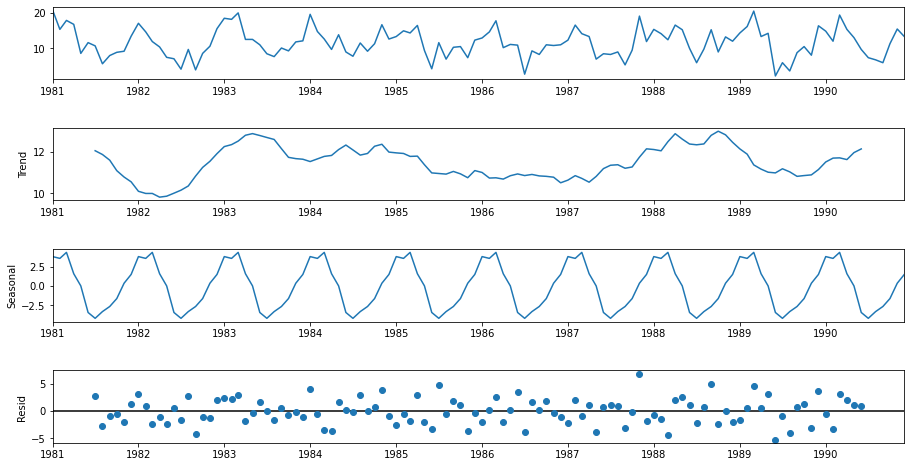

(date
 1981-01-01   NaN
 1981-02-01   NaN
 1981-03-01   NaN
 1981-04-01   NaN
 1981-05-01   NaN
               ..
 1990-08-01   NaN
 1990-09-01   NaN
 1990-10-01   NaN
 1990-11-01   NaN
 1990-12-01   NaN
 Freq: MS, Name: trend, Length: 120, dtype: float64,
 date
 1981-01-01    3.830671
 1981-02-01    3.596412
 1981-03-01    4.378356
 1981-04-01    1.598727
 1981-05-01    0.014468
                 ...   
 1990-08-01   -3.331366
 1990-09-01   -2.667477
 1990-10-01   -1.634606
 1990-11-01    0.362616
 1990-12-01    1.506597
 Freq: MS, Name: seasonal, Length: 120, dtype: float64,
 date
 1981-01-01   NaN
 1981-02-01   NaN
 1981-03-01   NaN
 1981-04-01   NaN
 1981-05-01   NaN
               ..
 1990-08-01   NaN
 1990-09-01   NaN
 1990-10-01   NaN
 1990-11-01   NaN
 1990-12-01   NaN
 Freq: MS, Name: resid, Length: 120, dtype: float64)

In [9]:
seasonal_decompose(df)

### Checking Stationarity

#### Visualization: Graphing the rolling statistics

In [10]:
def analyze_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

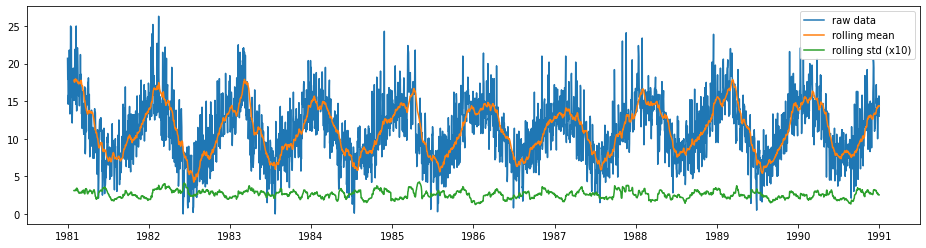

In [11]:
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['temp'], 'raw data')

#### Augmented Dickey-Fuller Test

https://www.statology.org/dickey-fuller-test-python/

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
- H1: The time series is stationary.

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
- H0: The process is trend stationary.
- H1: The series has a unit root (series is not stationary).

In [12]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [13]:
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -4.44480492
p-value                          0.00024708
Lags Used                       20.00000000
Number of Observations Used   3629.00000000
Critical Value (1%)             -3.43215323
Critical Value (5%)             -2.86233677
Critical Value (10%)            -2.56719413
dtype: float64


In [14]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [15]:
KPSS_test(df)

Results of KPSS Test:
Test Statistic           0.05570613
p-value                  0.10000000
Lags Used               36.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [16]:
# Checking stationarity with linear time-series
y_test = df.copy()
tmp = []
for i in range(len(y_test)):
    tmp.append(i)
y_test['temp'] = tmp
ADF_test(y_test)

Results of Dickey-Fuller Test:
Test Statistic                  11.34293252
p-value                          1.00000000
Lags Used                       16.00000000
Number of Observations Used   3633.00000000
Critical Value (1%)             -3.43215125
Critical Value (5%)             -2.86233589
Critical Value (10%)            -2.56719366
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [17]:
# Checking stationarity with sinusoidal data
y_test = df.copy()
tmp = []
for i in range(len(y_test)):
    tmp.append(np.sin(np.pi/2 * i / 365 + 1))
y_test['temp'] = tmp
ADF_test(y_test)

Results of Dickey-Fuller Test:
Test Statistic                -2940191052832.64892578
p-value                                    0.00000000
Lags Used                                  5.00000000
Number of Observations Used             3644.00000000
Critical Value (1%)                       -3.43214580
Critical Value (5%)                       -2.86233349
Critical Value (10%)                      -2.56719238
dtype: float64


### Checking Trending

#### Detrending

Results of Dickey-Fuller Test:
Test Statistic                  -4.18720920
p-value                          0.00069253
Lags Used                       20.00000000
Number of Observations Used   3265.00000000
Critical Value (1%)             -3.43235443
Critical Value (5%)             -2.86242564
Critical Value (10%)            -2.56724144
dtype: float64


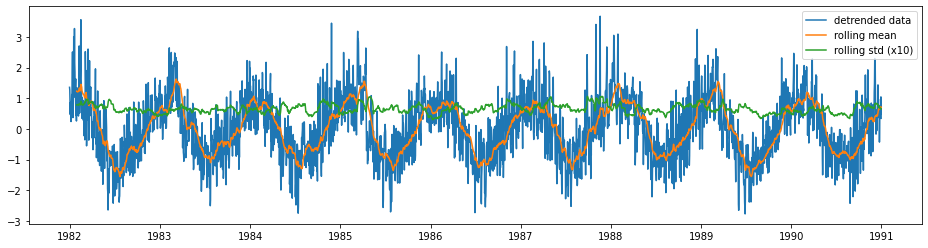

In [18]:
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(df_detrend['temp'].dropna(), 'detrended data')
ADF_test(df_detrend.dropna())

#### Differencing

Results of Dickey-Fuller Test:
Test Statistic                 -19.03653215
p-value                          0.00000000
Lags Used                        5.00000000
Number of Observations Used   3279.00000000
Critical Value (1%)             -3.43234586
Critical Value (5%)             -2.86242185
Critical Value (10%)            -2.56723943
dtype: float64


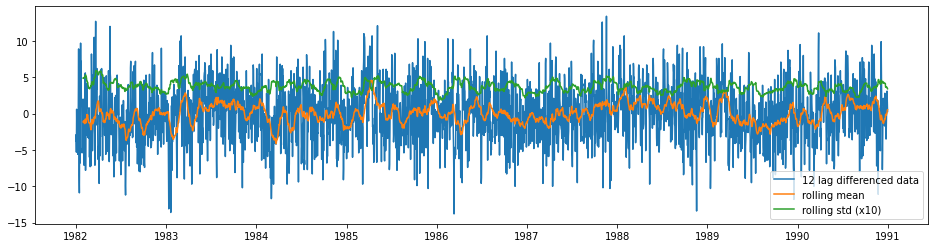

In [19]:
df_12lag =  df - df.shift(365)

analyze_stationarity(df_12lag['temp'].dropna(), '12 lag differenced data')
ADF_test(df_12lag.dropna())

#### Detrending + Differencing

Results of Dickey-Fuller Test:
Test Statistic                 -17.91947936
p-value                          0.00000000
Lags Used                        5.00000000
Number of Observations Used   2915.00000000
Critical Value (1%)             -3.43259531
Critical Value (5%)             -2.86253203
Critical Value (10%)            -2.56729808
dtype: float64


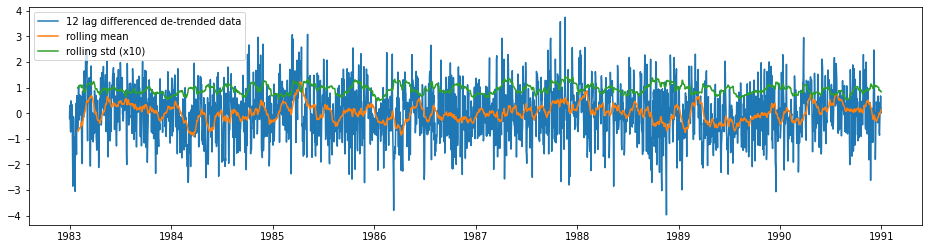

In [20]:
df_365lag_detrend =  df_detrend - df_detrend.shift(365)

analyze_stationarity(df_365lag_detrend['temp'].dropna(), '12 lag differenced de-trended data')
ADF_test(df_365lag_detrend.dropna())

### Create Training & Testing Datasets

In [21]:
y = df['temp']
y_to_train = y[:'1987-12-31']
y_to_val = y['1988-01-01':]
predict_date = len(y) - len(y[:'1987-12-31'])

### Forecasting models

#### Simple Exponential Smoothing (SES)

Suitable for time series data without trend or seasonal components

In [22]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train, y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    # specific smoothing level
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))    
    plt.plot(y_to_val.index, fcast1, marker='o', color='blue', label=f'smoothing_level={smoothing_level}')    
    fit1.fittedvalues.plot(marker='o',  color='blue', label=f'smoothing_level={smoothing_level}')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print(f'The Root Mean Squared Error of our forecasts with smoothing level of {smoothing_level} is {round(np.sqrt(mse1), 2)}')
    
    # auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    plt.plot(y_to_val.index, fcast2.values, marker='o', color='green', label=f'smoothing_level=auto')
    fit2.fittedvalues.plot(marker='o', color='green', label=f'smoothing_level=auto')
    
    mse2 = ((fcast2 - y_to_test.values) ** 2).mean()
    print(f'The Root Mean Squared Error of our forecasts with auto optimization is {round(np.sqrt(mse2), 2)}')
    
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has 

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 5.96
The Root Mean Squared Error of our forecasts with auto optimization is 5.26


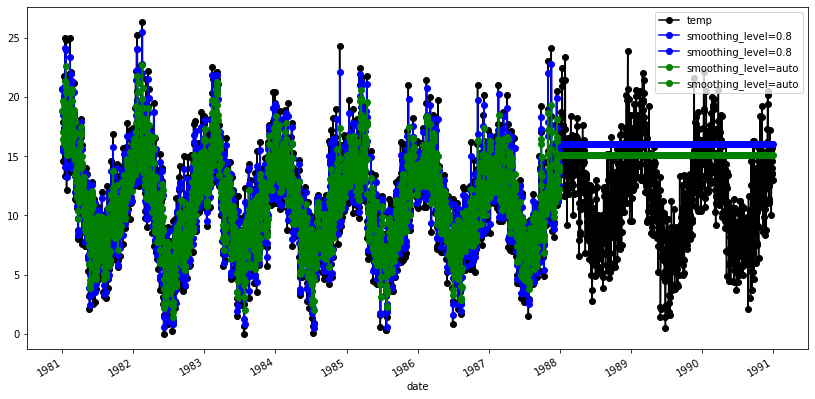

In [23]:
ses(y, y_to_train, y_to_val, 0.8, predict_date)

#### Holt’s Linear Trend Method

Suitable for time series data with a trend component but without a seasonal component

In [24]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    plt.plot(y_to_val.index, fcast1, color='blue', marker="o")

    plt.show()

The Root Mean Squared Error of Holts Linear trend 270.7


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


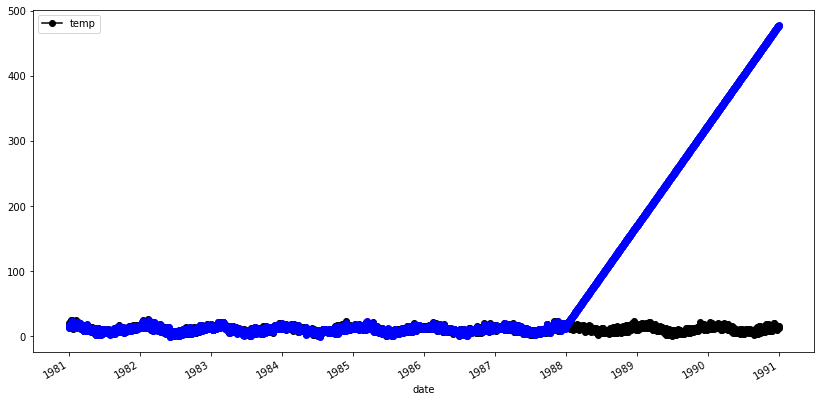

In [25]:
holt(y, y_to_train, y_to_val, 0.6, 0.2, predict_date)

#### Holt-Winters’ Seasonal Method

Suitable for time series data with trend and/or seasonal components

In [26]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped_trend=True).fit(use_boxcox=True)
    fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
    mse2 = ((fcast2 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))

    fit1.fittedvalues.plot(style='--', color='red')
    plt.plot(y_to_val.index, fcast1, color='red', marker="o", markersize=1)
    fit2.fittedvalues.plot(style='--', color='green')
    plt.plot(y_to_val.index, fcast2, color='green', marker="o", markersize=1)

    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-pac

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 3.68


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=365 and a Box-Cox transformation 3.12


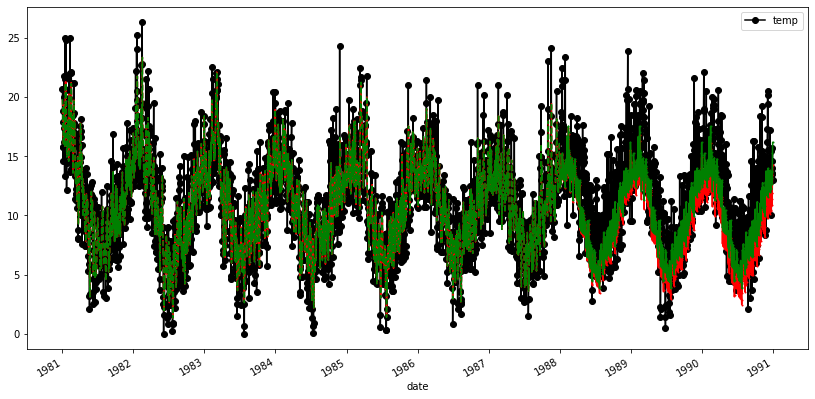

In [27]:
y_to_train_pos = y_to_train.copy()
y_to_train_pos[y_to_train_pos.values == 0] = 1
y_to_val_pos = y_to_val.copy()
y_to_val_pos[y_to_val_pos.values == 0] = 1

holt_win_sea(y, y_to_train_pos, y_to_val_pos, 365, predict_date)